# Sequential Model

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.convnet import *
from cs231n.solver import Solver
from cs231n.data_utils import get_CIFAR10_data
from cs231n.sequential import *
from cs231n import test
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['axes.formatter.useoffset'] = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load CIFAR10

In [2]:
data = get_CIFAR10_data()

for n, d in data.items():
    if n.startswith('X'):
        d /= 127.0
    print n, d.shape

num_val = 2000
val_data = {
    'X_train': data['X_train'][:num_val],
    'y_train': data['y_train'][:num_val],
    'X_val': data['X_val'],
    'y_val': data['y_val']
}

X_val (1000, 3, 32, 32)
X_train (49000, 3, 32, 32)
X_test (1000, 3, 32, 32)
y_val (1000,)
y_train (49000,)
y_test (1000,)


## Gradcheck

**TODO**

* Fix Dense backprop
* Relu between Dense
* Gradcheck on f(x) = u.T \* g(v \* x) où g : mon réseau; u,v : random vectors

In [43]:
# Prepare a small dataset
total_examples = 3
X = data['X_train'][:total_examples, :, :8, :8]
y = data['y_train'][:total_examples]
print X.shape

(3, 3, 8, 8)
0.196183743773 0.655725145515


In [183]:
# Build the model
lr = 3.464142e-02
reg = 1.060586e-04
batch_shape = (50,) + data['X_train'].shape[1:]
model = Sequential(batch_shape=batch_shape, weight_scale=1.0, reg=reg, dtype=np.float64)
for num_filters in [8, 16, 32]:
    model.add(ConvBnRelu(num_filters))
    model.add(ConvBnRelu(num_filters))
    model.add(Pool())
for num_neurons in [256, 128]:
    model.add(Dense(num_neurons, weight_init='sqrt_2_over_n'))
    model.add(Relu())
model.add(Dense(num_neurons=10, weight_init='sqrt_2_over_n'))
model.build(loss=Softmax())
model.print_params()
print ''
model.print_layers()

Model parameters:
ConvBnRelu1_W        (8, 3, 3, 3)
ConvBnRelu1_b        (8,)
ConvBnRelu1_beta     (8,)
ConvBnRelu1_gamma    (8,)
ConvBnRelu2_W        (8, 8, 3, 3)
ConvBnRelu2_b        (8,)
ConvBnRelu2_beta     (8,)
ConvBnRelu2_gamma    (8,)
ConvBnRelu3_W        (16, 8, 3, 3)
ConvBnRelu3_b        (16,)
ConvBnRelu3_beta     (16,)
ConvBnRelu3_gamma    (16,)
ConvBnRelu4_W        (16, 16, 3, 3)
ConvBnRelu4_b        (16,)
ConvBnRelu4_beta     (16,)
ConvBnRelu4_gamma    (16,)
ConvBnRelu5_W        (32, 16, 3, 3)
ConvBnRelu5_b        (32,)
ConvBnRelu5_beta     (32,)
ConvBnRelu5_gamma    (32,)
ConvBnRelu6_W        (32, 32, 3, 3)
ConvBnRelu6_b        (32,)
ConvBnRelu6_beta     (32,)
ConvBnRelu6_gamma    (32,)
Dense1_W             (512, 256)
Dense1_b             (256,)
Dense2_W             (256, 128)
Dense2_b             (128,)
Dense3_W             (128, 10)
Dense3_b             (10,)
Total 183922

Layer outputs:
InputLayer1      out: (50, 3, 32, 32)
ConvBnRelu1      out: (50, 8, 32, 32)
ConvBnRe

Train acc 1.0   Loss 0.417043459145


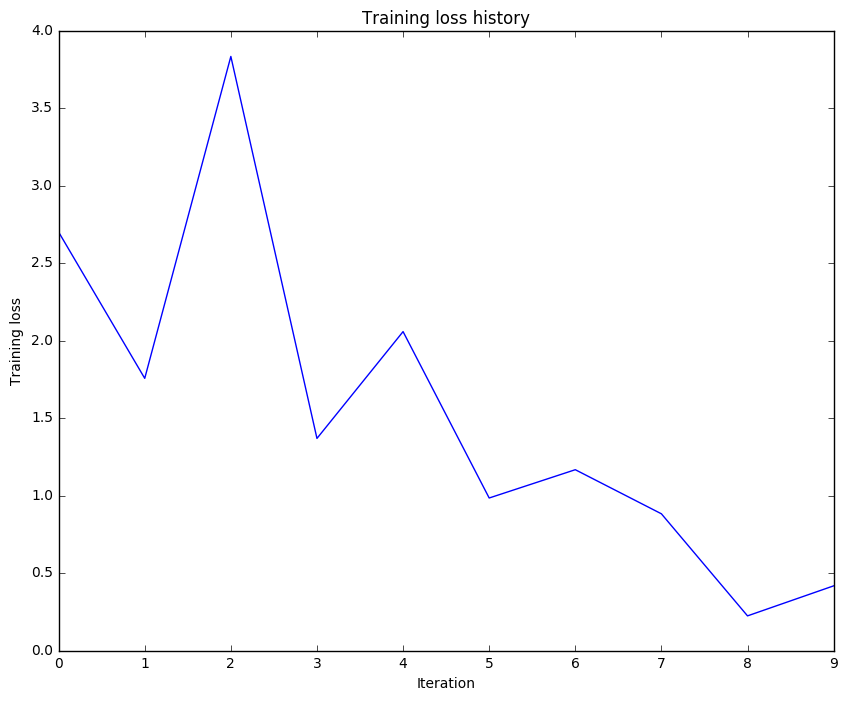

In [102]:
# Train the model a bit
solver = Solver(model, {'X_train': X, 'y_train': y, 'X_val': X, 'y_val': y},
                num_epochs=10, batch_size=X.shape[0],
                update_rule='adam',
                optim_config={
                  'learning_rate': lr,
                },
                verbose=False, print_every=1)
solver.train()
print 'Train acc', solver.train_acc_history[-1], '  Loss', solver.loss_history[-1]
plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

In [103]:
# Perform gradient check
test.gradient_check(model, X, y)


--- Gradient check ---
Max relative error:   (h = 1e-06)
Param                Error                                   Ana           Num          
Dense1_W             2.101274e-04  uncomfortable     avgval: 2.363497e-03  2.363498e-03 
Dense1_b             2.891305e-06                    avgval: 7.765718e-03  7.765715e-03 
Dense2_W             2.217252e-05                    avgval: 1.824976e-02  1.824976e-02 
Dense2_b             2.308361e-06                    avgval: 1.840074e-02  1.840074e-02 
Dense3_W             1.327402e-05                    avgval: 2.328581e-02  2.328581e-02 
Dense3_b             3.354189e-07                    avgval: 9.750922e-03  9.750919e-03 
Dense4_W             7.194919e-06                    avgval: 4.764273e-02  4.764233e-02 
Dense4_b             2.716196e-07                    avgval: 5.025158e-02  5.025155e-02 


## Hyperparameter search

In [196]:
results = {}
best_solver = None
best_model = None
best_acc = -1
best_loss = 10000
best_params = None

(Iteration 1 / 14700) loss: 4.351709
(Epoch 0 / 15) train acc: 0.113000; val_acc: 0.106000
(Iteration 2 / 14700) loss: 3.603637
(Iteration 3 / 14700) loss: 4.000894
(Iteration 4 / 14700) loss: 3.824935
(Iteration 5 / 14700) loss: 4.013979
(Iteration 6 / 14700) loss: 3.574642
(Iteration 7 / 14700) loss: 3.819104
(Iteration 8 / 14700) loss: 3.267116
(Iteration 9 / 14700) loss: 3.318181
(Iteration 10 / 14700) loss: 3.553186
(Iteration 11 / 14700) loss: 3.490904
(Iteration 12 / 14700) loss: 3.267551
(Iteration 13 / 14700) loss: 3.354269
(Iteration 14 / 14700) loss: 3.234851
(Iteration 15 / 14700) loss: 3.409393
(Iteration 16 / 14700) loss: 3.349814
(Iteration 17 / 14700) loss: 3.189426
(Iteration 18 / 14700) loss: 3.358762
(Iteration 19 / 14700) loss: 3.260574
(Iteration 20 / 14700) loss: 3.373480
(Iteration 21 / 14700) loss: 2.917864
(Iteration 22 / 14700) loss: 3.228835
(Iteration 23 / 14700) loss: 3.257188
(Iteration 24 / 14700) loss: 3.231630
(Iteration 25 / 14700) loss: 3.297267
(Iter

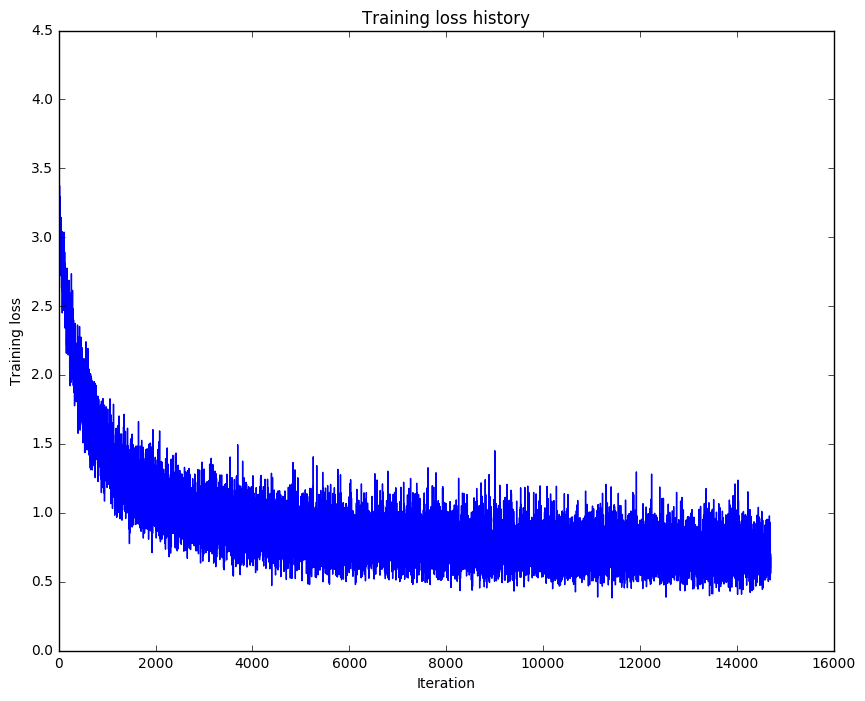

In [197]:
# Hyper parameter search

def uniform(minv, maxv):
    return np.random.rand() * (maxv - minv) + minv

batch_size = 50
batch_shape = (batch_size,) + val_data['X_train'].shape[1:]

discarded = 0
for _ in range(1):
    # r 2.967037e-03   lr 4.242814e-03
    weight_scale = 1.0  # 10 ** uniform(-4, -2)
    learning_rate = 9e-04  # 10 ** uniform(-2.8, -2)
    reg = 2.967037e-03  # 10 ** uniform(-3.3, -2.5)
    
    model = Sequential(batch_shape=batch_shape, weight_scale=weight_scale, reg=reg)
    for num_filters in [8, 16, 32]:
        model.add(ConvBnRelu(num_filters))
        model.add(ConvBnRelu(num_filters))
        model.add(Pool())
    for num_neurons in [256, 128]:
        model.add(Dense(num_neurons, weight_init='sqrt_2_over_n'))
        model.add(Relu())
    model.add(Dense(num_neurons=10, weight_init='sqrt_2_over_n'))
    model.build(loss=Softmax())
    
    # {'X_train': X, 'y_train': y, 'X_val': X, 'y_val': y}
    solver = Solver(model, data,
                num_epochs=15, batch_size=batch_size,
                update_rule='adam',
                optim_config={
                  'learning_rate': learning_rate,
                },
                verbose=True, print_every=1)
    #solver = Solver(model, val_data,
    #                print_every=10, num_epochs=5, batch_size=batch_size,
    #                update_rule='adam',
    #                optim_config={
    #                  'learning_rate': learning_rate,
    #                },
    #                verbose=True)
    solver.train()
    acc = solver.val_acc_history[-1]
    #acc = solver.train_acc_history[-1]
    final_loss = solver.loss_history[-1]
    format_str = '{:e} {:e}  final l: {:.5f}  acc: {}'
    print format_str.format(reg, learning_rate, final_loss, acc)
    #if np.max(solver.loss_history) > 5:
    #    discarded += 1
    #    continue
    plt.plot(solver.loss_history, '-')
    params = (reg, learning_rate, weight_scale)
    results[params] = (acc, final_loss)
    if acc > best_acc:
        best_acc = acc
        best_loss = final_loss
        best_solver = solver
        best_model = model
        best_params = params

print 'Discarded:', discarded
print 'Best params: {:e} {:e} {:e}'.format(*best_params)
        
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

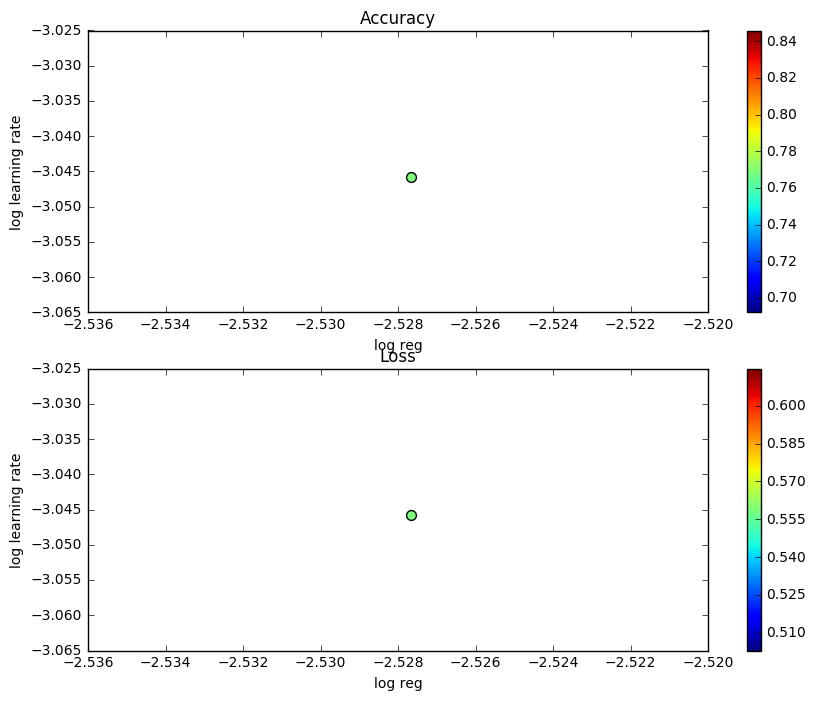

In [199]:
# Visualize the cross-validation results
import math
marker_size = 50
x_scatter, x_label = np.array([np.log10(x[0]) for x in results]), 'log reg'
#x_scatter, x_label = np.array([np.log10(x[2]) for x in results]), 'log weight scale'
y_scatter, y_label = np.array([np.log10(x[1]) for x in results]), 'log learning rate'

# plot validation accuracy
things = [(0, 'Accuracy', 1),
          (1, 'Loss', -1)]
for i, th in enumerate(things):
    color_data_i, title, sens = th
    colors = np.array([results[x][color_data_i] for x in results])
    plt.subplot(2, 1, i+1)
    order = np.argsort(colors)[::sens]
    plt.scatter(x_scatter[order], y_scatter[order], marker_size, c=colors[order])
    plt.colorbar()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
plt.show()

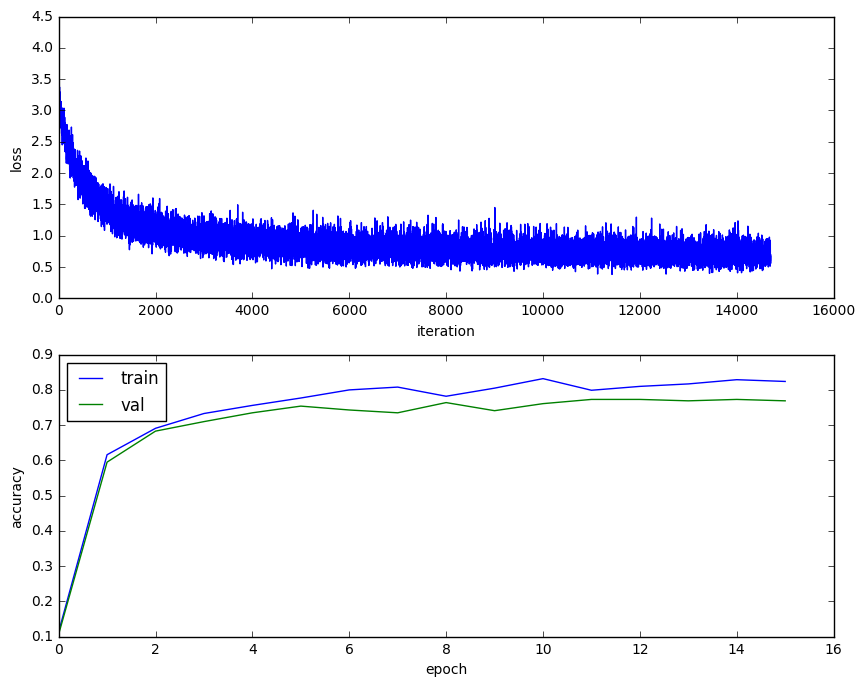

In [198]:
plt.subplot(2, 1, 1)
plt.plot(best_solver.loss_history, '-')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(best_solver.train_acc_history, '-')
plt.plot(best_solver.val_acc_history, '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [149]:
print best_model.params['ConvBnRelu1_W'].shape

(8, 3, 3, 3)


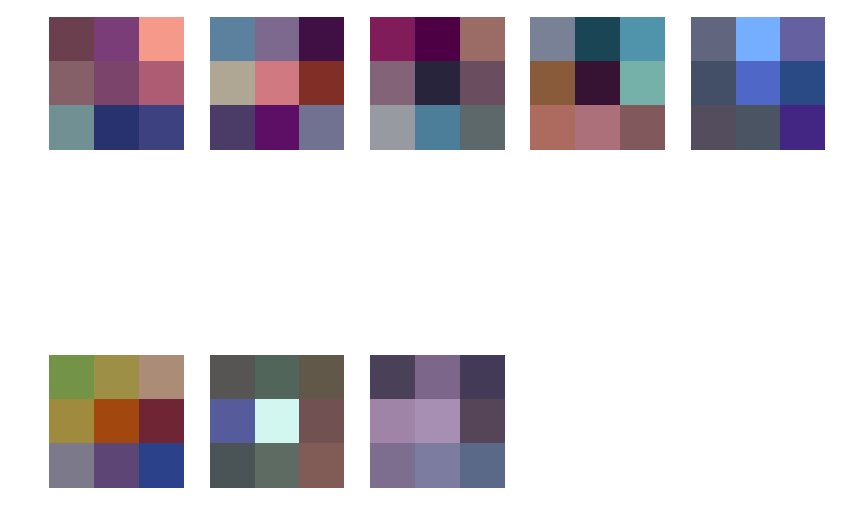

In [209]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_model.params['ConvBnRelu1_W']
w = np.moveaxis(w, 0, -1)  # --> (C, 3, 3, 8)
w = np.moveaxis(w, 0, 2)   # --> (3, 3, C, 8)
w = w.reshape(3, 3, 3, -1)
w_min, w_max = np.min(w), np.max(w)
for i in xrange(w.shape[-1]):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')

In [208]:
import pickle
filename = 'weights-{:.4f}.bin'.format(best_solver.loss_history[-1])
with open(filename, 'wb') as f:
    pickle.dump(best_model.params, f, pickle.HIGHEST_PROTOCOL)

In [207]:
#with open('weights.bin', 'rb') as f:
#    w = pickle.load(f)
#for p in sorted(w.keys()):
#    print p